<h1 align="center"> Image Captioning (8 points) </h1>

In this notebook you will teach a network to do image captioning
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

### Data preprocessing

In [1]:
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [2]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [3]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [4]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        word_counts.update(sentence)

In [5]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [6]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [7]:
#try it out on several descriptions of a random image
as_matrix(captions[13])

array([[  1, 213, 214, 215, 185,   6,  24, 216, 217, 169, 141,   2,   3],
       [  1, 217, 169,  63, 136, 214, 218,  10, 219,  12,   2,   3,   3],
       [  1,  24, 131, 217, 169,  13,  14, 214,  15, 220,  12,   2,   3],
       [  1,  24, 169,  58, 112, 214, 123, 221,  15, 222, 223,  12,   2],
       [  1, 214,  15, 109, 224,  99, 107,  24, 217, 169,  12,   2,   3]])

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [9]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size) 
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_hid[None], initial_cell[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [10]:
network = CaptionNet(n_tokens)

In [11]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [12]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    loss = nn.CrossEntropyLoss(ignore_index=pad_ix)(
        logits_for_next.view(-1, logits_for_next.shape[-1]),
        captions_ix_next.view(-1)
    ).view(-1)

    
    return loss

In [13]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [14]:
opt = torch.optim.Adam(network.parameters(), lr=1e-3)

# Training

* First implement the batch generator
* Than train the network as usual

In [15]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [16]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None, device='cpu'):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32).to(device),\
           torch.tensor(batch_captions_ix, dtype=torch.int64).to(device)
    

In [17]:
generate_batch(img_codes,captions,3)

(tensor([[0.1281, 0.2057, 0.1251,  ..., 0.4444, 0.1011, 0.4326],
         [0.1552, 0.2497, 0.4554,  ..., 0.9646, 1.0859, 0.3927],
         [0.7109, 0.1240, 0.2398,  ..., 0.0390, 0.6274, 0.0341]]),
 tensor([[   1,   24,  279,   41,   94,    6,   24,  217,  169,  170,  175,  176,
            35,   24,  486, 2550, 8334,  472,   12,    2],
         [   1,   24,   57, 3260,   35,   45,  199,  136,    7,    8, 4277,  634,
            14, 8223,   12,    2,    3,    3,    3,    3],
         [   1,   45,   54,  511,   99,  374,   45, 3496, 3485,   12,    2,    3,
             3,    3,    3,    3,    3,    3,    3,    3]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [19]:
batch_size = 32  # adjust me
n_epochs = 200  # adjust me
n_batches_per_epoch = 100  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [20]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

network = network.to(device)

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size, device=device))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        opt.zero_grad()
        loss_t.backward()
        opt.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size, device=device))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.23it/s]



Epoch: 0, train loss: 5.427985219955445, val loss: 4.696257209777832


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.26it/s]



Epoch: 1, train loss: 4.449667966365814, val loss: 4.232269668579102


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.00it/s]



Epoch: 2, train loss: 4.163358881473541, val loss: 3.9076682567596435


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.08it/s]



Epoch: 3, train loss: 3.9806876015663146, val loss: 3.909007453918457


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.71it/s]



Epoch: 4, train loss: 3.882889621257782, val loss: 3.8813254833221436


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.28it/s]



Epoch: 5, train loss: 3.706905012130737, val loss: 3.6276390075683596


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.11it/s]



Epoch: 6, train loss: 3.603206353187561, val loss: 3.556038808822632


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.77it/s]



Epoch: 7, train loss: 3.50474351644516, val loss: 3.4595588207244874


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.18it/s]



Epoch: 8, train loss: 3.4221904277801514, val loss: 3.394809865951538


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.77it/s]



Epoch: 9, train loss: 3.360054430961609, val loss: 3.3597058773040773


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.79it/s]



Epoch: 10, train loss: 3.308132529258728, val loss: 3.269830274581909


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.46it/s]



Epoch: 11, train loss: 3.241815528869629, val loss: 3.223103094100952


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.18it/s]



Epoch: 12, train loss: 3.2098593282699586, val loss: 3.1107526302337645


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.53it/s]



Epoch: 13, train loss: 3.191697690486908, val loss: 3.043060636520386


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.20it/s]



Epoch: 14, train loss: 3.1384193825721742, val loss: 3.136656618118286


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.16it/s]



Epoch: 15, train loss: 3.070985748767853, val loss: 3.1075010299682617


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.83it/s]



Epoch: 16, train loss: 3.073704948425293, val loss: 3.123234415054321


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.99it/s]



Epoch: 17, train loss: 3.065191571712494, val loss: 2.9800711631774903


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.56it/s]



Epoch: 18, train loss: 3.0362351036071775, val loss: 3.076985549926758


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.64it/s]



Epoch: 19, train loss: 3.0072858119010926, val loss: 3.1492567539215086


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.20it/s]



Epoch: 20, train loss: 3.0014293074607847, val loss: 3.0181202411651613


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.38it/s]



Epoch: 21, train loss: 2.9544483065605163, val loss: 2.9985732555389406


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.00it/s]



Epoch: 22, train loss: 2.9606615710258484, val loss: 2.7799144268035887


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.94it/s]



Epoch: 23, train loss: 2.912511920928955, val loss: 2.958539533615112


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.83it/s]



Epoch: 24, train loss: 2.9062532114982607, val loss: 3.0022627830505373


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.48it/s]



Epoch: 25, train loss: 2.950807409286499, val loss: 2.838038969039917


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.73it/s]



Epoch: 26, train loss: 2.919717755317688, val loss: 2.9693198680877684


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.19it/s]



Epoch: 27, train loss: 2.8782149529457093, val loss: 2.9423142433166505


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.45it/s]



Epoch: 28, train loss: 2.8729979634284972, val loss: 3.0886412620544434


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.68it/s]



Epoch: 29, train loss: 2.8466055512428285, val loss: 2.8258117198944093


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.23it/s]



Epoch: 30, train loss: 2.8486865377426147, val loss: 2.944956111907959


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.32it/s]



Epoch: 31, train loss: 2.8185333943367006, val loss: 2.9775538444519043


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.91it/s]



Epoch: 32, train loss: 2.8254378914833067, val loss: 2.9435911655426024


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.65it/s]



Epoch: 33, train loss: 2.8410969972610474, val loss: 2.72385892868042


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.56it/s]



Epoch: 34, train loss: 2.8014270210266115, val loss: 2.653815507888794


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.50it/s]



Epoch: 35, train loss: 2.8170394134521484, val loss: 2.891126203536987


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.41it/s]



Epoch: 36, train loss: 2.801278476715088, val loss: 2.848612117767334


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.00it/s]



Epoch: 37, train loss: 2.781171667575836, val loss: 2.883741331100464


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.48it/s]



Epoch: 38, train loss: 2.7809063744544984, val loss: 2.8563581466674806


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.11it/s]



Epoch: 39, train loss: 2.7538228940963747, val loss: 2.677349662780762


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.48it/s]



Epoch: 40, train loss: 2.7599679255485534, val loss: 2.897494983673096


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.12it/s]



Epoch: 41, train loss: 2.7442582416534425, val loss: 2.655329942703247


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.56it/s]



Epoch: 42, train loss: 2.7687712359428405, val loss: 2.780021142959595


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.83it/s]



Epoch: 43, train loss: 2.7458458065986635, val loss: 2.7129279136657716


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.74it/s]



Epoch: 44, train loss: 2.7132343864440918, val loss: 2.7265568733215333


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.16it/s]



Epoch: 45, train loss: 2.732083311080933, val loss: 2.5911363124847413


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.35it/s]



Epoch: 46, train loss: 2.7175317549705507, val loss: 2.898835325241089


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.48it/s]



Epoch: 47, train loss: 2.6927538657188417, val loss: 2.921509838104248


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.60it/s]



Epoch: 48, train loss: 2.7041746735572816, val loss: 2.640656614303589


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.34it/s]



Epoch: 49, train loss: 2.7177247333526613, val loss: 2.7287483692169188


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.20it/s]



Epoch: 50, train loss: 2.6571720957756044, val loss: 2.8042782306671143


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.62it/s]



Epoch: 51, train loss: 2.676003625392914, val loss: 2.823865270614624


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.47it/s]



Epoch: 52, train loss: 2.667261691093445, val loss: 2.668229866027832


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.47it/s]



Epoch: 53, train loss: 2.6826894593238833, val loss: 2.721622657775879


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.45it/s]



Epoch: 54, train loss: 2.6286822962760925, val loss: 2.5716793060302736


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.88it/s]



Epoch: 55, train loss: 2.6738159322738646, val loss: 2.663267803192139


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.33it/s]



Epoch: 56, train loss: 2.6853675484657287, val loss: 2.6562946319580076


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.41it/s]



Epoch: 57, train loss: 2.65426029920578, val loss: 2.8633962154388426


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.28it/s]



Epoch: 58, train loss: 2.6338726902008056, val loss: 2.7541691303253173


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.25it/s]



Epoch: 59, train loss: 2.6678226828575133, val loss: 2.7211025238037108


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.36it/s]



Epoch: 60, train loss: 2.6270247292518616, val loss: 2.7595106601715087


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.13it/s]



Epoch: 61, train loss: 2.6205716562271117, val loss: 2.748930788040161


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.39it/s]



Epoch: 62, train loss: 2.6658720350265503, val loss: 2.5868647575378416


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.42it/s]



Epoch: 63, train loss: 2.6344236731529236, val loss: 2.7233442306518554


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.90it/s]



Epoch: 64, train loss: 2.6099462294578553, val loss: 2.7048959255218508


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.02it/s]



Epoch: 65, train loss: 2.65092693567276, val loss: 2.483055019378662


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.53it/s]



Epoch: 66, train loss: 2.6141337823867796, val loss: 2.586900758743286


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.53it/s]



Epoch: 67, train loss: 2.631612248420715, val loss: 2.6135346412658693


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.26it/s]



Epoch: 68, train loss: 2.6178190994262693, val loss: 2.5859525203704834


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.67it/s]



Epoch: 69, train loss: 2.6182012295722963, val loss: 2.6158963203430177


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.94it/s]



Epoch: 70, train loss: 2.6167527985572816, val loss: 2.7164729595184327


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.85it/s]



Epoch: 71, train loss: 2.595784170627594, val loss: 2.6568809032440184


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.00it/s]



Epoch: 72, train loss: 2.6069988203048706, val loss: 2.8409990787506105


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.17it/s]



Epoch: 73, train loss: 2.6012665224075318, val loss: 2.7377944469451903


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.91it/s]



Epoch: 74, train loss: 2.5839255619049073, val loss: 2.615721845626831


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.55it/s]



Epoch: 75, train loss: 2.605565021038055, val loss: 2.646684980392456


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.59it/s]



Epoch: 76, train loss: 2.5400012016296385, val loss: 2.7596806049346925


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.20it/s]



Epoch: 77, train loss: 2.6022897291183473, val loss: 2.5240180015563967


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.85it/s]



Epoch: 78, train loss: 2.5889522433280945, val loss: 2.6717480659484862


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.17it/s]



Epoch: 79, train loss: 2.544530725479126, val loss: 2.57154541015625


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.45it/s]



Epoch: 80, train loss: 2.5886011505126953, val loss: 2.6722537517547607


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.31it/s]



Epoch: 81, train loss: 2.590274910926819, val loss: 2.6255885124206544


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.97it/s]



Epoch: 82, train loss: 2.56372013092041, val loss: 2.6852363109588624


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.59it/s]



Epoch: 83, train loss: 2.5693429064750672, val loss: 2.616444444656372


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.43it/s]



Epoch: 84, train loss: 2.539142529964447, val loss: 2.561137390136719


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.36it/s]



Epoch: 85, train loss: 2.5963973808288574, val loss: 2.7556252479553223


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.61it/s]



Epoch: 86, train loss: 2.5417528676986696, val loss: 2.7062820911407472


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.68it/s]



Epoch: 87, train loss: 2.5546632027626037, val loss: 2.607496213912964


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.23it/s]



Epoch: 88, train loss: 2.5544974184036255, val loss: 2.6161343574523928


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.95it/s]



Epoch: 89, train loss: 2.5137526535987855, val loss: 2.525613212585449


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.38it/s]



Epoch: 90, train loss: 2.554525339603424, val loss: 2.642120695114136


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.33it/s]



Epoch: 91, train loss: 2.553371503353119, val loss: 2.600585412979126


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.02it/s]



Epoch: 92, train loss: 2.563783986568451, val loss: 2.709036445617676


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.43it/s]



Epoch: 93, train loss: 2.533666286468506, val loss: 2.63478102684021


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.19it/s]



Epoch: 94, train loss: 2.5519671702384947, val loss: 2.6629019260406492


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.64it/s]



Epoch: 95, train loss: 2.570436964035034, val loss: 2.5746697425842284


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.91it/s]



Epoch: 96, train loss: 2.5397793745994566, val loss: 2.538261556625366


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.59it/s]



Epoch: 97, train loss: 2.523246545791626, val loss: 2.6633067607879637


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.97it/s]



Epoch: 98, train loss: 2.5399111914634704, val loss: 2.6790979385375975


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.07it/s]



Epoch: 99, train loss: 2.514151873588562, val loss: 2.7029764652252197


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.68it/s]



Epoch: 100, train loss: 2.531998105049133, val loss: 2.6783864498138428


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.17it/s]



Epoch: 101, train loss: 2.522302680015564, val loss: 2.700134515762329


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.22it/s]



Epoch: 102, train loss: 2.5060030603408814, val loss: 2.4316272735595703


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.52it/s]



Epoch: 103, train loss: 2.5317040407657623, val loss: 2.5801568984985352


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.44it/s]



Epoch: 104, train loss: 2.5083189511299135, val loss: 2.671469783782959


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.45it/s]



Epoch: 105, train loss: 2.4989071011543276, val loss: 2.4798235416412355


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.02it/s]



Epoch: 106, train loss: 2.501615879535675, val loss: 2.6075361251831053


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.55it/s]



Epoch: 107, train loss: 2.5049517941474915, val loss: 2.526403474807739


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.11it/s]



Epoch: 108, train loss: 2.4868868684768675, val loss: 2.497068405151367


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.56it/s]



Epoch: 109, train loss: 2.5013794016838076, val loss: 2.653539228439331


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.67it/s]



Epoch: 110, train loss: 2.5107212376594545, val loss: 2.6300885677337646


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.56it/s]



Epoch: 111, train loss: 2.4920499515533447, val loss: 2.6189908027648925


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.46it/s]



Epoch: 112, train loss: 2.492386043071747, val loss: 2.687418746948242


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.97it/s]



Epoch: 113, train loss: 2.51701762676239, val loss: 2.5757072448730467


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.36it/s]



Epoch: 114, train loss: 2.5047051095962525, val loss: 2.64158616065979


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.39it/s]



Epoch: 115, train loss: 2.4834209418296815, val loss: 2.6444079875946045


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.10it/s]



Epoch: 116, train loss: 2.5028587126731874, val loss: 2.573572778701782


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.08it/s]



Epoch: 117, train loss: 2.4840414452552797, val loss: 2.5440745830535887


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.11it/s]



Epoch: 118, train loss: 2.497953190803528, val loss: 2.6277795791625977


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.74it/s]



Epoch: 119, train loss: 2.513272442817688, val loss: 2.67692608833313


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.41it/s]



Epoch: 120, train loss: 2.4577604293823243, val loss: 2.5675538539886475


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.36it/s]



Epoch: 121, train loss: 2.495739517211914, val loss: 2.6644595146179197


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.41it/s]



Epoch: 122, train loss: 2.4642547392845153, val loss: 2.511302185058594


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.91it/s]



Epoch: 123, train loss: 2.4455643486976624, val loss: 2.622222089767456


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.91it/s]



Epoch: 124, train loss: 2.5142087650299074, val loss: 2.4842740058898927


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.14it/s]



Epoch: 125, train loss: 2.4813267970085144, val loss: 2.5214263439178466


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.50it/s]



Epoch: 126, train loss: 2.48027715921402, val loss: 2.713629674911499


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.76it/s]



Epoch: 127, train loss: 2.4581358337402346, val loss: 2.5650206565856934


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.70it/s]



Epoch: 128, train loss: 2.494128031730652, val loss: 2.4720876693725584


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.59it/s]



Epoch: 129, train loss: 2.4707871222496034, val loss: 2.4469862937927247


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.88it/s]



Epoch: 130, train loss: 2.473816728591919, val loss: 2.6421616077423096


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.29it/s]



Epoch: 131, train loss: 2.496390497684479, val loss: 2.5819045066833497


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.59it/s]



Epoch: 132, train loss: 2.4610380959510803, val loss: 2.584848737716675


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.93it/s]



Epoch: 133, train loss: 2.4763520836830137, val loss: 2.7214925289154053


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.13it/s]



Epoch: 134, train loss: 2.4703478050231933, val loss: 2.4748520374298097


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.91it/s]



Epoch: 135, train loss: 2.473161826133728, val loss: 2.534743404388428


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.35it/s]



Epoch: 136, train loss: 2.45423082113266, val loss: 2.6423690795898436


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.29it/s]



Epoch: 137, train loss: 2.4647365260124205, val loss: 2.5697527885437013


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.50it/s]



Epoch: 138, train loss: 2.467116494178772, val loss: 2.523449945449829


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.96it/s]



Epoch: 139, train loss: 2.419552813768387, val loss: 2.4766375064849853


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.59it/s]



Epoch: 140, train loss: 2.491443955898285, val loss: 2.626061296463013


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.91it/s]



Epoch: 141, train loss: 2.4544136261940004, val loss: 2.400834846496582


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.11it/s]



Epoch: 142, train loss: 2.44498398065567, val loss: 2.6564830780029296


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.50it/s]



Epoch: 143, train loss: 2.451957070827484, val loss: 2.543184280395508


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.19it/s]



Epoch: 144, train loss: 2.408881120681763, val loss: 2.524863862991333


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.88it/s]



Epoch: 145, train loss: 2.4560764408111573, val loss: 2.453560543060303


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.50it/s]



Epoch: 146, train loss: 2.4391724944114683, val loss: 2.5271597385406492


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.10it/s]



Epoch: 147, train loss: 2.4222280550003052, val loss: 2.4687153339385985


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.84it/s]



Epoch: 148, train loss: 2.4755844402313234, val loss: 2.4735360145568848


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.86it/s]



Epoch: 149, train loss: 2.472007901668549, val loss: 2.5449808120727537


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.30it/s]



Epoch: 150, train loss: 2.4527061104774477, val loss: 2.553606081008911


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.59it/s]



Epoch: 151, train loss: 2.450620150566101, val loss: 2.399360466003418


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.23it/s]



Epoch: 152, train loss: 2.442852863073349, val loss: 2.6245874881744387


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.68it/s]



Epoch: 153, train loss: 2.4523547673225403, val loss: 2.5187819957733155


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.08it/s]



Epoch: 154, train loss: 2.429923942089081, val loss: 2.5076066493988036


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.88it/s]



Epoch: 155, train loss: 2.4143691086769103, val loss: 2.5198415756225585


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.07it/s]



Epoch: 156, train loss: 2.42107186794281, val loss: 2.7590946197509765


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.53it/s]



Epoch: 157, train loss: 2.4109318113327025, val loss: 2.532619047164917


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.79it/s]



Epoch: 158, train loss: 2.413538203239441, val loss: 2.4162755012512207


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.16it/s]



Epoch: 159, train loss: 2.395806337594986, val loss: 2.4997695446014405


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.43it/s]



Epoch: 160, train loss: 2.456119384765625, val loss: 2.5483285427093505


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.16it/s]



Epoch: 161, train loss: 2.4200380444526672, val loss: 2.639782524108887


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.70it/s]



Epoch: 162, train loss: 2.4605565214157106, val loss: 2.4411798477172852


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.50it/s]



Epoch: 163, train loss: 2.432619261741638, val loss: 2.45467095375061


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.56it/s]



Epoch: 164, train loss: 2.41686687707901, val loss: 2.5029430866241453


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.02it/s]



Epoch: 165, train loss: 2.4345695614814757, val loss: 2.418629217147827


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.13it/s]



Epoch: 166, train loss: 2.4252033042907715, val loss: 2.435375928878784


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.17it/s]



Epoch: 167, train loss: 2.4154269349575044, val loss: 2.532790184020996


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.23it/s]



Epoch: 168, train loss: 2.412838407754898, val loss: 2.6657269954681397


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.05it/s]



Epoch: 169, train loss: 2.4221467661857603, val loss: 2.6162873268127442


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.02it/s]



Epoch: 170, train loss: 2.4253900015354155, val loss: 2.6798491954803465


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.58it/s]



Epoch: 171, train loss: 2.409447318315506, val loss: 2.44082293510437


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.89it/s]



Epoch: 172, train loss: 2.427408833503723, val loss: 2.4259023666381836


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.38it/s]



Epoch: 173, train loss: 2.396824836730957, val loss: 2.4701740741729736


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.34it/s]



Epoch: 174, train loss: 2.4229981827735902, val loss: 2.504905939102173


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.11it/s]



Epoch: 175, train loss: 2.4206032609939574, val loss: 2.4443285942077635


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.06it/s]



Epoch: 176, train loss: 2.395870622396469, val loss: 2.557123899459839


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.45it/s]



Epoch: 177, train loss: 2.428457601070404, val loss: 2.5159597873687742


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.11it/s]



Epoch: 178, train loss: 2.423934438228607, val loss: 2.433435249328613


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.56it/s]



Epoch: 179, train loss: 2.423700280189514, val loss: 2.496054935455322


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.14it/s]



Epoch: 180, train loss: 2.4200997948646545, val loss: 2.519941711425781


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.41it/s]



Epoch: 181, train loss: 2.433666684627533, val loss: 2.4990877151489257


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.25it/s]



Epoch: 182, train loss: 2.4145208644866942, val loss: 2.6608840942382814


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.85it/s]



Epoch: 183, train loss: 2.406453456878662, val loss: 2.4803332328796386


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.27it/s]



Epoch: 184, train loss: 2.3909060335159302, val loss: 2.4957690238952637


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.65it/s]



Epoch: 185, train loss: 2.4021026587486265, val loss: 2.543775463104248


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.76it/s]



Epoch: 186, train loss: 2.394125915765762, val loss: 2.4750176429748536


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.42it/s]



Epoch: 187, train loss: 2.397738139629364, val loss: 2.3584310531616213


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.21it/s]



Epoch: 188, train loss: 2.3976417446136473, val loss: 2.4555739879608156


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.00it/s]



Epoch: 189, train loss: 2.371218591928482, val loss: 2.531314182281494


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.48it/s]



Epoch: 190, train loss: 2.3856027376651765, val loss: 2.44970326423645


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.94it/s]



Epoch: 191, train loss: 2.424912443161011, val loss: 2.444818925857544


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.14it/s]



Epoch: 192, train loss: 2.424384958744049, val loss: 2.5241114139556884


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.08it/s]



Epoch: 193, train loss: 2.390530433654785, val loss: 2.509969711303711


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.11it/s]



Epoch: 194, train loss: 2.3934843802452086, val loss: 2.4555423736572264


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.36it/s]



Epoch: 195, train loss: 2.376267807483673, val loss: 2.4846236228942873


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.92it/s]



Epoch: 196, train loss: 2.3996397280693054, val loss: 2.5463063716888428


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.25it/s]



Epoch: 197, train loss: 2.3714182531833647, val loss: 2.4273605823516844


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.67it/s]



Epoch: 198, train loss: 2.3965691781044005, val loss: 2.410102939605713


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.33it/s]



Epoch: 199, train loss: 2.3731092047691345, val loss: 2.410180997848511
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [21]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [22]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck.cuda(), prefix_ix.cuda())[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [23]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image

# remark: !wget doesn't work for me (I have Windows), so I commented the following line and downloaded an image manually

#!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  # This is added back by InteractiveShellApp.init_path()


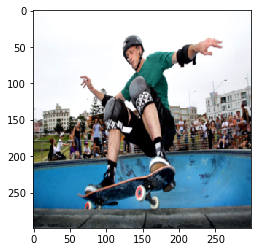

In [24]:
plt.imshow(img)

In [25]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is doing a skateboard trick in the air .
a man doing a skateboard trick in a park .
a man jumping in the air on a skateboard .
a skateboarder doing a trick on a ramp .
a man doing a skateboard trick in a park .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man doing a skateboard trick in a park .
a man jumping in a skate board in the air
a man on a skateboard doing a trick on a ramp .


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


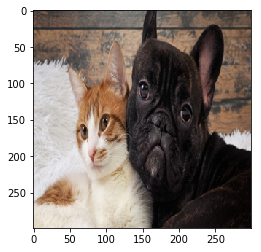

a black and white photo of a cat sitting on a couch .
a black and white cat is sitting next to a dog .
a black and white cat is sitting on a chair
a black and white cat is sitting on a couch .
a black and white cat is sitting on a chair .
a black and white cat is sitting on a couch .
a black and white cat is sitting on a couch .
a black and white cat is sitting on a couch .
a black and white cat sitting on top of a couch .
a black and white cat sitting on a couch .


In [26]:
#!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img2.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

Good hunting!
![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)

Here I provide 10 examples for what I consider a good captioning and 10 examples for the bad one. All the used photos are going to be attached to the solution in Canvas.

### Wins

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  import sys


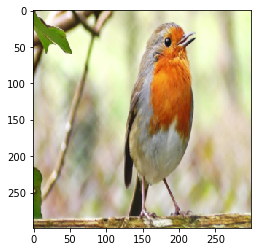

a small bird sitting on top of a tree branch .
a small bird with a branch in its mouth .
a bird sitting on top of a tree branch .
a bird perched on a branch in a tree .
a bird sitting on a branch in a tree .
a bird is perched on a tree branch .
a bird is perched on a tree branch .
a bird sitting on top of a tree branch .
a bird perched on a tree branch in a forest .
a bird sitting on a tree branch in a forest .


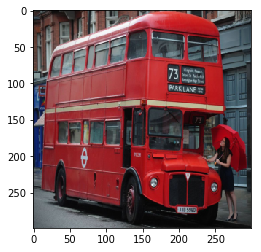

a double decker bus parked on the side of a street .
a double decker bus parked in front of a building .
a double decker bus parked on the street .
a red double decker bus parked in front of a building .
a red double decker bus parked on the side of a road .
a red double decker bus parked on the side of a road .
a red double decker bus parked in front of a building .
a double decker bus parked in a lot .
a red double decker bus parked in a lot .
a red double decker bus parked in front of a building .


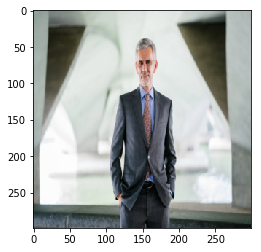

a man in a suit and tie holding a red umbrella .
a man in a suit and tie with a suit and tie .
a man in a suit and tie standing in front of a building .
a man in a suit and tie holding a wine glass .
a man in a suit and tie with a suit and tie .
a man in a suit and tie holding a red tie .
a man in a suit and tie standing in front of a building .
a man in a suit and tie standing in front of a building .
a man in a suit and tie holding a red tie .
a man in a suit and tie holding a red tie .


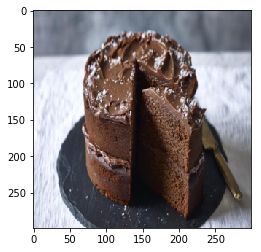

a cake with a fork and knife on top of it .
a cake with a fork and knife on it .
a cake with a fork and knife on top of it .
a cake with a fork and knife on top of it .
a cake with a fork and knife on top of it .
a cake with a fork and knife on top of it .
a cake with a fork and knife on top of it .
a cake with a fork and knife on top of it .
a cake with a fork and knife on top of it .
a cake with a fork and knife on a plate .


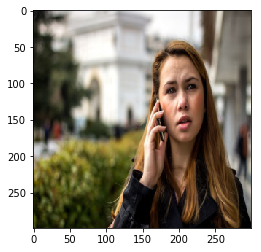

a woman is posing with a cell phone in her hand .
a woman in a dress is holding a cell phone .
a woman wearing a tie and a black hat .
a woman holding a cell phone in her hands .
a woman with a tie and a dress standing in front of a building .
a woman is smiling while holding a cell phone .
a woman wearing a tie and a man in a black dress is holding a cell phone .
a woman is smiling while holding a cell phone .
a woman in a red dress is holding a cell phone .
a woman in a dress is holding a cell phone .


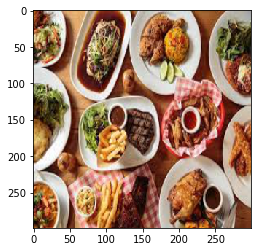

a group of doughnuts are sitting on a table .
a variety of food and a glass of wine .
a variety of food items on a table .
a variety of food items on a table .
a variety of food and a glass of wine .
a variety of food and a glass of wine .
a variety of food and a glass of wine on a table .
a variety of food and a glass of wine .
a bunch of food that are on a table .
a variety of food items on a table .


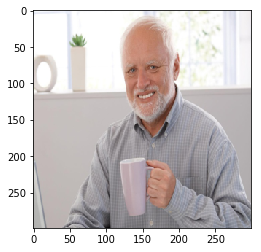

a man in a white shirt is sitting at a table .
a man is sitting at a table with a plate of food .
a man is sitting at a table with a laptop .
a man in a white shirt and a white tie sitting in front of a table .
a man sitting at a table with a laptop computer .
a man and a woman sitting at a table with a laptop computer .
a man in a white shirt and glasses holding a glass of wine .
a man sitting at a table with a laptop computer .
a man is sitting at a table with a plate of food .
a man in a suit and tie holding a glass of wine .


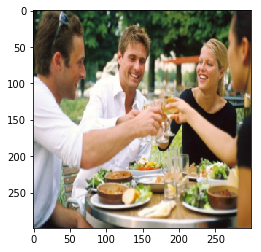

a group of people eating food at a table .
a group of people sitting around a table with food .
a group of people sitting at a table with food .
a group of people sitting around a table with food .
a group of people sitting around a table with food .
a man and woman sitting at a table with food .
a group of people sitting at a table with food .
a group of people sitting at a table with food .
a group of people eating food at a table .
a group of people sitting at a table with a plate of food .


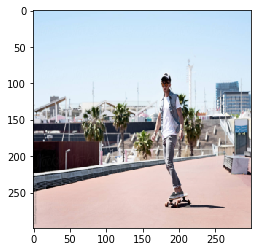

a man in a red shirt is doing a trick on a skateboard .
a man in a red shirt is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man in a red shirt is doing a trick on a skateboard .
a man in a red shirt is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man in a white shirt is doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man that is standing on a skateboard in a park .


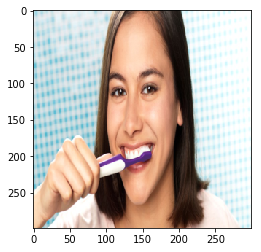

a woman holding a tooth brush in her hands .
a woman brushing her teeth with a tooth brush .
a woman holding a tooth brush in her hands .
a woman holding a tooth brush in her hands .
a woman brushing her teeth with a tooth brush .
a woman holding a tooth brush in her hands .
a woman holding a toothbrush in her hands .
a woman holding a tooth brush in her hands .
a woman holding a tooth brush in her hands .
a woman holding a toothbrush in her hands .


In [52]:
import glob

for path in glob.glob('data/test/wins/*'):
    img = plt.imread(path)
    img = imresize(img, (299, 299)).astype('float32') / 255.

    plt.imshow(img)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))

### Fails

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


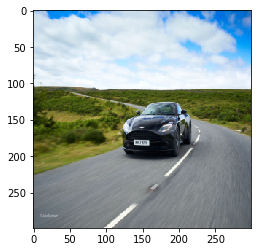

a man is standing in a parking lot with a red umbrella .
a car is parked on the side of the road .
a man is standing in the middle of a street .
a man standing on a road with a car on the side of it .
a man is standing in the middle of a road .
a man standing on a street with a car on the side of it .
a man standing in a parking lot with a surfboard .
a man standing on a road with a car on the side of it .
a man standing in a car with a surfboard .
a man is standing in a parking lot with a surfboard .


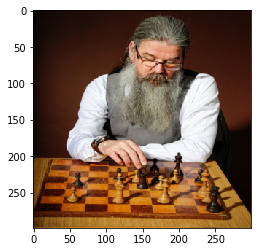

a man and a woman cutting a cake with a knife .
a man is cutting into a cake with a knife .
a man in a suit and tie holding a knife .
a man cutting a cake with a knife .
a man and a woman are cutting a cake .
a man and a woman cutting a cake with a knife .
a man in a suit and tie is holding a knife .
a man cutting a cake with a knife .
a man in a suit and tie is holding a knife .
a man cutting a cake with a knife .


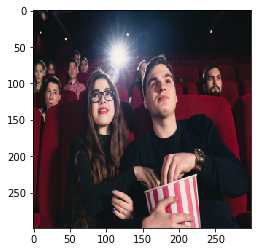

a group of people standing around a table with a cake .
a group of people standing around a table with a cake .
a group of people standing around a table with a cake .
a man and a woman are standing in front of a clock .
a man and a woman are standing in front of a store .
a group of people standing around a table with a cake .
a man and a woman are standing in front of a store .
a group of people standing in front of a store .
a group of people standing around a table with a cake .
a group of people standing around a table with a cake .


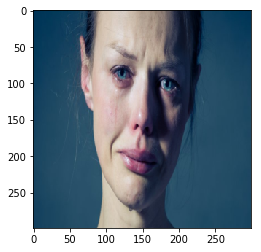

a man in a striped shirt holding a cell phone .
a man wearing a black shirt and a black tie .
a man with a beard and a neck tie .
a man wearing a suit and tie holding a white frisbee .
a man in a tuxedo holding a cell phone .
a man with a beard and a hat and a woman .
a man wearing a tie and a black hat .
a man wearing a black shirt and a white shirt and a tie .
a man with a beard and a neck tie .
a man with a beard and a beard .


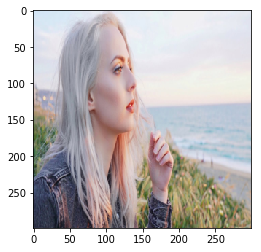

a woman holding a red umbrella in her hands .
a woman with a hat and a hat on top of a boat .
a woman standing next to a red fire hydrant .
a woman is holding a yellow umbrella in her hand .
a woman with a pink umbrella is sitting in the grass .
a woman with a cell phone in her hand .
a woman with a hat and a red tie .
a woman is holding a frisbee in her hands .
a woman with a red jacket and a pink dress standing in front of a building .
a woman in a pink dress is holding a cell phone .


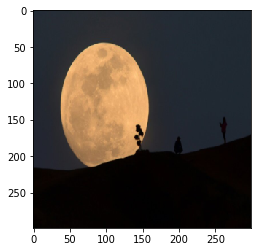

a small group of people standing around a table .
a bunch of bananas hanging on a wall .
a group of people standing around a table with a cake .
a small group of people standing around a table .
a bunch of bananas are in a room .
a small group of people standing around a table .
a bunch of bananas hanging on a wall
a small group of people standing around a table .
a bunch of small children playing with a frisbee
a couple of teddy bears sitting on top of a table .


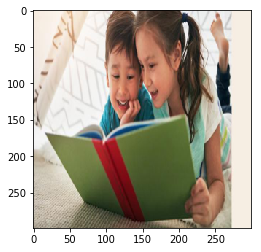

a young boy is sitting on a laptop computer .
a young boy is sitting on a laptop computer .
a little boy is sitting in front of a laptop computer .
a little boy is sitting at a table with a laptop .
a woman sitting on a couch with a laptop computer .
a young boy is sitting on a laptop .
a little boy is sitting at a table with a laptop .
a young boy is sitting on a laptop computer .
a little girl holding a laptop computer on a table .
a little girl holding a laptop computer on a table .


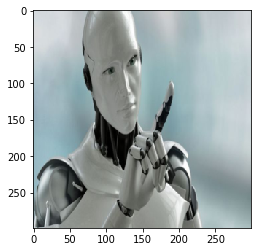

a woman in a pink shirt is holding a teddy bear .
a woman holding a stuffed animal on a cell phone .
a woman is holding a teddy bear with a man in a suit and tie .
a woman wearing a hat and sunglasses holding a teddy bear .
a woman is holding a knife in her hands .
a woman wearing a hat and a hat and a teddy bear .
a woman wearing a hat and a hat and a dog .
a woman in a hat is holding a teddy bear .
a woman wearing a hat and sunglasses holding a teddy bear .
a woman wearing a hat and sunglasses holding a cell phone .


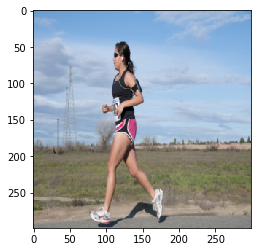

a man is flying a kite in a park .
a man is flying a kite in a park .
a man holding a frisbee in his hands .
a man in a blue shirt is flying a kite .
a woman is standing on a beach with a kite .
a woman is standing on a skateboard in the street .
a man is flying a kite on a sunny day .
a man is flying a kite in a blue sky .
a man is jumping in the air on a skateboard .
a man in a blue shirt is flying a kite .


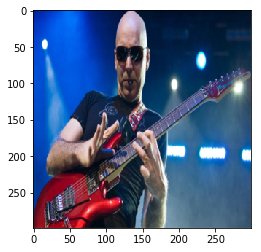

a man in a suit and tie standing in a room .
a man in a black shirt and tie with a hat .
a man in a tuxedo holding a frisbee .
a man in a suit and tie holding a bat .
a man with a tie and a hat on
a man in a suit and tie holding a bat .
a man in a suit and tie holding a bat .
a man in a suit and tie in a room .
a man in a suit and tie with a hat on .
a man with a tie and a hat on .


In [53]:
for path in glob.glob('data/test/fails/*'):
    img = plt.imread(path)
    img = imresize(img, (299, 299)).astype('float32') / 255.

    plt.imshow(img)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))